In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, product
import sys,time
import os
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from WLaSDI import WLaSDI
from WLaSDI_wendy import WLaSDI_wendy
import matplotlib
from scipy.interpolate import interp2d, Rbf

### Importing simulations, training parameters, etc.

In [2]:
# Given parameters
nx = 64
ny = 64
nxy = (ny)*(nx) # 3364
nt = 100
tstop = 1
dt = tstop/nt
t = np.arange(0, tstop, 0.01)

In [3]:
training_rad = np.arange(180,230,20) 
training_iv = np.arange(180,230,20)
training_values = list(product(training_rad,training_iv))
nset = len(training_values)
training_values = np.array(training_values)

x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
X,Y = np.meshgrid(x,y, indexing = 'xy')

In [41]:
snapshot_matrix = np.empty([nxy, len(training_values)*nt])
for foo, sample in enumerate(training_values):
    ex = np.load('./data/ex16_w_{}_a_{}.npz'.format(sample[0], sample[1]), allow_pickle = True)
    ex = ex.f.arr_0
    ex = ex.T
    snapshot_matrix[:, nt*foo:nt*(foo+1)] = ex

def addNoise(x, noise_ratio):
    signal_power = np.sqrt(np.mean(x**2))
    sigma = noise_ratio*signal_power
    noise = np.random.normal(0, sigma, x.shape)
    xobs = x + noise
    return xobs

noise_level = 0.1
snapshot_matrix = addNoise(snapshot_matrix, noise_level).astype('float32')


### Apply POD

In [42]:
u,s,vh = LA.svd(snapshot_matrix)
sv_mass = np.cumsum(s)
sv_count =  6 #[i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.999][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

6 [0.25123546 0.26453233 0.26834095 0.26980752 0.27103773 0.27226666]


### Generate latent-space trajectories from training data

In [43]:
latent_space_SS = []
for foo in range(nset):
    latent_space = np.matmul(phi.T, snapshot_matrix[:, nt*foo:nt*(foo+1)])
    latent_space_SS.append(latent_space.T)
    

### Apply WLaSDI

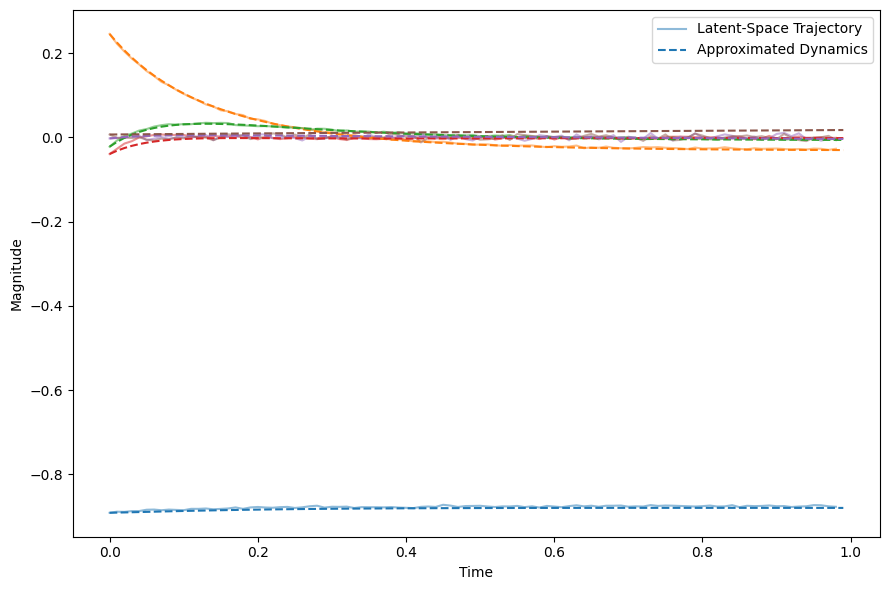

In [44]:
#Use WSINDy
degree = 1
normal = np.amax(np.abs(latent_space_SS))
WLaSDI_model = WLaSDI(phi.T, phi, Local = False, Coef_interp = True, Coef_interp_method = Rbf, nearest_neigh=4)
WLaSDI_coef = WLaSDI_model.train_dynamics(latent_space_SS, training_values, t, gamma = 0, L = 8, overlap = 0.9, degree = 1, normal = normal)

(100, 6)
Global approach


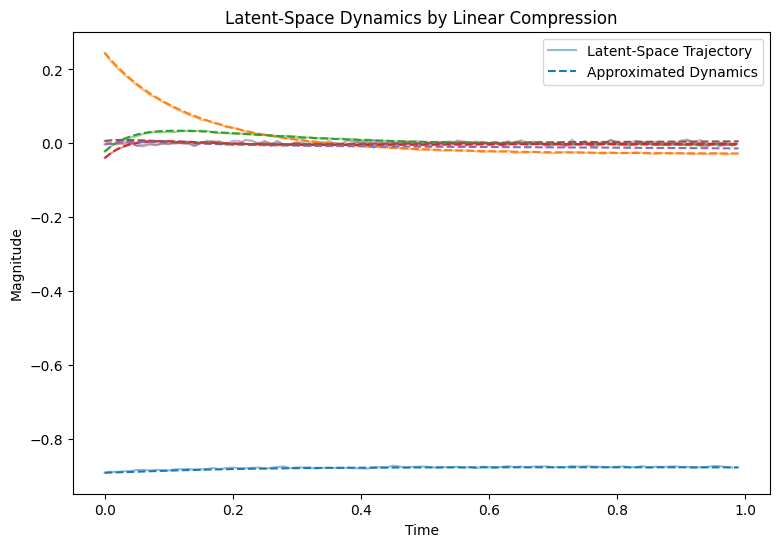

In [45]:
from LaSDI import LaSDI
#Use WSINDy
degree = 1
normal = np.amax(np.abs(latent_space_SS))
LaSDI_model = LaSDI(phi.T, phi, Local = False, Coef_interp = True, Coef_interp_method = Rbf, nearest_neigh=4)
LaSDI_coef = LaSDI_model.train_dynamics(latent_space_SS, training_values, t, normal = normal)


In [9]:
features = [
        [lambda x0, x1, x2, x3, x4, x5: x0*0 + 1, lambda x0, x1, x2, x3, x4, x5: x5, lambda x0, x1, x2, x3, x4, x5: x4, lambda x0, x1, x2, x3, x4, x5: x3, lambda x0, x1, x2, x3, x4, x5: x2, lambda x0, x1, x2, x3, x4, x5: x1, lambda x0, x1, x2, x3, x4, x5: x0 ],
        [lambda x0, x1, x2, x3, x4, x5: x0*0 + 1, lambda x0, x1, x2, x3, x4, x5: x5, lambda x0, x1, x2, x3, x4, x5: x4, lambda x0, x1, x2, x3, x4, x5: x3, lambda x0, x1, x2, x3, x4, x5: x2, lambda x0, x1, x2, x3, x4, x5: x1, lambda x0, x1, x2, x3, x4, x5: x0 ],
        [lambda x0, x1, x2, x3, x4, x5: x0*0 + 1, lambda x0, x1, x2, x3, x4, x5: x5, lambda x0, x1, x2, x3, x4, x5: x4, lambda x0, x1, x2, x3, x4, x5: x3, lambda x0, x1, x2, x3, x4, x5: x2, lambda x0, x1, x2, x3, x4, x5: x1, lambda x0, x1, x2, x3, x4, x5: x0 ],
        [lambda x0, x1, x2, x3, x4, x5: x0*0 + 1, lambda x0, x1, x2, x3, x4, x5: x5, lambda x0, x1, x2, x3, x4, x5: x4, lambda x0, x1, x2, x3, x4, x5: x3, lambda x0, x1, x2, x3, x4, x5: x2, lambda x0, x1, x2, x3, x4, x5: x1, lambda x0, x1, x2, x3, x4, x5: x0 ],
        [lambda x0, x1, x2, x3, x4, x5: x0*0 + 1, lambda x0, x1, x2, x3, x4, x5: x5, lambda x0, x1, x2, x3, x4, x5: x4, lambda x0, x1, x2, x3, x4, x5: x3, lambda x0, x1, x2, x3, x4, x5: x2, lambda x0, x1, x2, x3, x4, x5: x1, lambda x0, x1, x2, x3, x4, x5: x0 ],
        [lambda x0, x1, x2, x3, x4, x5: x0*0 + 1, lambda x0, x1, x2, x3, x4, x5: x5, lambda x0, x1, x2, x3, x4, x5: x4, lambda x0, x1, x2, x3, x4, x5: x3, lambda x0, x1, x2, x3, x4, x5: x2, lambda x0, x1, x2, x3, x4, x5: x1, lambda x0, x1, x2, x3, x4, x5: x0 ],
]

WLaSDI_model = WLaSDI_wendy(phi.T, phi, Local = True, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh = 9)
WLaSDI_coef = WLaSDI_model.train_dynamics(latent_space_SS, training_values, t, features = features, normal = normal, gamma = 0.0001, LS_vis = True, ls_meth = "rLS", subsample=1, mt_params=[2**i for i in range(3)], mt_min = 8, mt_max = 50, toggle_VVp_svd = 0)

Local approach WITHOUT SINDy coefficient interpolation


### Generate ROM and visulaize results

In [55]:
FOM = np.load('./data/ex16_w_{}_a_{}.npz'.format(185,205), allow_pickle = True)
FOM = FOM.f.arr_0
time_start = time.time()
FOM_recon = WLaSDI_model.generate_ROM(FOM[0], np.array([185,205]),t)
LaSDI_time = time.time()-time_start

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


In [56]:
FOM_re = np.empty(nt)
for j in range(nt):
    FOM_re[j] = LA.norm(FOM_recon[j]-FOM[j])/LA.norm(FOM[j])
max_re = np.amax(FOM_re)*100
speed_up = 4.7/LaSDI_time

Text(0.5, 1.0, 'Relative Error')

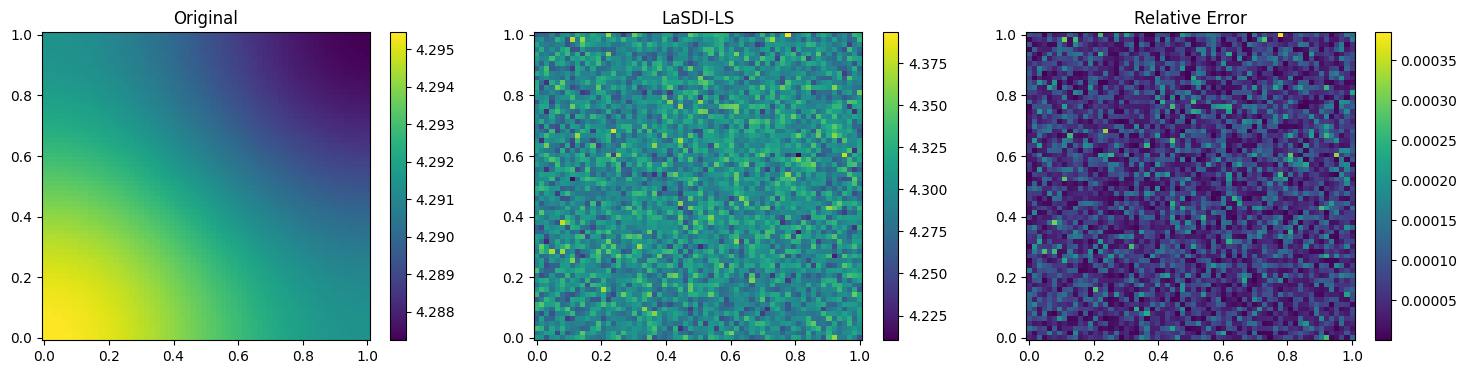

In [57]:
k=99
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
fig.set_size_inches(18,4)
z1=ax1.pcolormesh(X,Y,FOM[k].reshape(nx,ny), shading = 'nearest')

fig.colorbar(z1, ax = ax1)
# ax1.axis('equal')
ax1.set_title('Original')
z1=ax2.pcolormesh(X,Y,FOM_recon[k].reshape(nx,ny), shading = 'nearest')
fig.colorbar(z1, ax = ax2)
# ax2.axis('equal')
ax2.set_title('LaSDI-LS')
ax3 = fig.add_subplot(1,3,3)
z1=ax3.pcolormesh(X,Y,np.abs(FOM_recon[k].reshape(nx,ny)-FOM[k].reshape(nx,ny))/LA.norm(FOM[k].reshape(nx,ny)), shading = 'nearest')
fig.colorbar(z1, ax = ax3)
# ax3.axis('equal')
ax3.set_title('Relative Error')

Text(0, 0.5, 'Relative Error (%)')

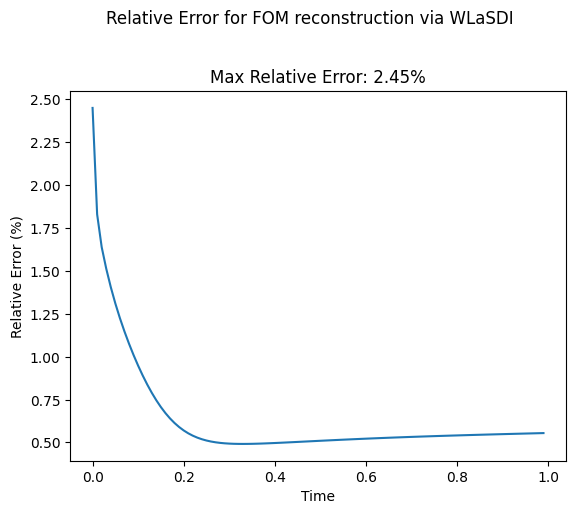

In [58]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via WLaSDI', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(max_re))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')